# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os

from PIL import Image
import pickle

In [33]:
% matplotlib tk

# Provided functions

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.axis('off')
    plt.imshow(im)
    print(f'Set at least {min_lines} lines to compute vanishing point')
    print(f'The delete and backspace keys act like right clicking')
    print(f'The enter key acts like middle clicking')
    while True:
        print('Click the two endpoints, use the right button (delete and backspace keys) to undo, and use the middle button to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print(f'Need at least {min_lines} lines, you have {n} now')
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(ax, im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10
    
    ax.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    ax.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    ax.set_xlim([bx1, bx2])
    ax.set_ylim([by2, by1])

# Your implementation

In [4]:
def get_vanishing_point(n,lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # <YOUR CODE>
    
    # A = np.sum(lines[:, :, np.newaxis] * lines[:, np.newaxis, :], axis=0)
    A = np.zeros((3, 3))
    for i in range(n):
        A += lines[:, i:i+1] @ lines[:, i:i+1].T
    # Solve for the nullspace of A
    u, s, vt = np.linalg.svd(A)
    vp = vt[-1, :]
    vp /= vp[-1]
    return vp


In [5]:
def get_horizon_line(vpoint1,vpoint2):
    """
    Calculates the ground horizon line.
    """
    # <YOUR CODE>
    dirn = np.cross(vpoint1,vpoint2)
    dirn /= np.sqrt(dirn[0]**2 + dirn[1]**2)
    
    return dirn

In [22]:
def plot_horizon_line(vpoint1, vpoint2, im, ax):
    """
    Plots the horizon line.
    """
    # <YOUR CODE>
    pot1 = vpoint1[:2] / vpoint1[2]
    pot2 = vpoint2[:2] / vpoint2[2]

    ax.imshow(im)
    ax.axline(pot1, pot2, c='g')
    ax.plot(pot1[0], pot1[1], 'ro')
    ax.plot(pot2[0], pot2[1], 'ro')

In [7]:
def get_camera_parameters(vpoints):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    # <YOUR CODE>
    vpoints /= vpoints[-1, :]
    vp1 = vpoints[:, 0]
    vp2 = vpoints[:, 1]
    vp3 = vpoints[:, 2]
    A = np.array([vp1 + vp2, vp1 + vp3, vp2 + vp3])
    b = np.array([vp1.dot(vp2), vp1.dot(vp3), vp2.dot(vp3)]) - 1
    x = np.linalg.lstsq(A.T.dot(A), A.T.dot(b), rcond=None)[0]
    px, py, k = x
    f = -2 * k - px**2 - py**2
    K = np.array([[f, 0, px], [0, f, py], [0, 0, 1]])
    return f, px, py, K

In [8]:
def get_rotation_matrix(vpoints, K):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR CODE>
    vpoints /= vpoints[-1, :]
    R = np.zeros((3, 3))
    R[:, 0] = K @ vpoints[:, 0]
    R[:, 1] = K @ vpoints[:, 1]
    R[:, 2] = np.cross(R[:, 0], R[:, 1])
    R[:, 0] /= np.linalg.norm(R[:, 0])
    R[:, 1] /= np.linalg.norm(R[:, 1])
    R[:, 2] /= np.linalg.norm(R[:, 2])
    return R


In [9]:
def get_homography(R, K):
    """
    Compute homography for transforming the image into fronto-parallel 
    views along the different axes.
    """
    # <YOUR CODE>
    H = K @ R
    H /= H[2, 2]
    return H

# Main function

In [10]:
im = np.asarray(Image.open('./eceb.jpg'))

# Also loads the vanishing line data if it exists in data.pickle file. 
# data.pickle is written using snippet in the next cell.
if os.path.exists('./data.pickle'):
    with open('./data.pickle', 'rb') as f:
        all_n, all_lines, all_centers = pickle.load(f)
    num_vpts = 3

In [ ]:
 # Click and save the line data for vanishing points. This snippet 
# opens up an interface for selecting points and writes them to 
# data.pickle file. The file is over-written.

# num_vpts = 3
# all_n, all_lines, all_centers = [], [], []

# for i in range(num_vpts):
#     print(f'Getting vanishing point {i}')
    
#     # Get at least three lines from user input
#     n_i, lines_i, centers_i = get_input_lines(im)
#     all_n.append(n_i)
#     all_lines.append(lines_i)
#     all_centers.append(centers_i)

# with open('data.pickle', 'wb') as f:
#     pickle.dump([all_n, all_lines, all_centers], f)

[[-1.91080224e+03  0.00000000e+00  0.00000000e+00]
 [ 9.38131166e+01  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[-1.91080224e+03  3.67966328e+03  0.00000000e+00]
 [ 9.38131166e+01 -1.05848093e+02  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00]]
[[-1.91080224e+03  3.67966328e+03  2.17582618e+03]
 [ 9.38131166e+01 -1.05848093e+02  5.63670907e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00]]


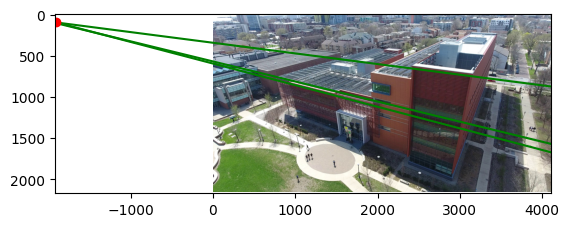

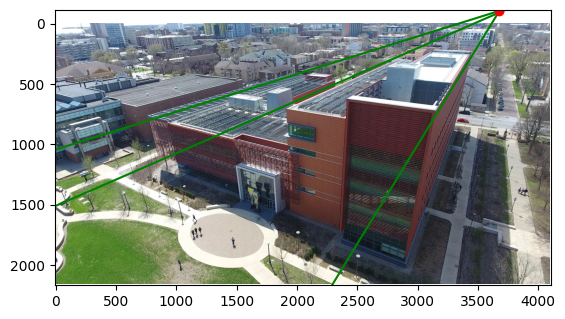

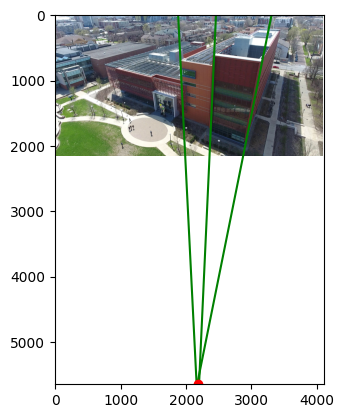

In [12]:
# Part (1)
# Computing vanishing points for each of the directions
vpts = np.zeros((3, num_vpts))

for i in range(num_vpts):
    fig = plt.figure(); ax = fig.gca()
    
    # <YOUR CODE> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(all_n[i],all_lines[i])
    print(vpts)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(ax, im, all_lines[i], vpts[:, i])
    fig.savefig('Q3_vp{:d}.pdf'.format(i), bbox_inches='tight')

0.03569183871611272
0.9993628433402271
-25.55329751895859


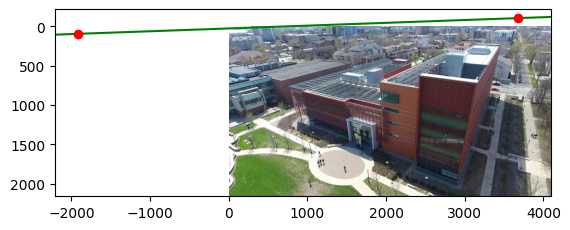

In [24]:
# Part (2) Computing and plotting the horizon
# <YOUR CODE> Get the ground horizon line
horizon_line = get_horizon_line(vpts[:, 0], vpts[:, 1])
print(horizon_line[0])
print(horizon_line[1])
print(horizon_line[2])
# <YOUR CODE> Plot the ground horizon line
fig = plt.figure(); ax = fig.gca()
plot_horizon_line(vpts[:, 0], vpts[:, 1], im, ax)
fig.savefig('Q3_horizon.pdf', bbox_inches='tight')

In [26]:
# Part (3) Computing Camera Parameters
# <YOUR CODE> Solve for the camera parameters (f, u, v)
f, u, v, K = get_camera_parameters(vpts)
print(f,u,v,K)

5274144.54223915 2014.5771455644888 1121.7752244881442 [[5.27414454e+06 0.00000000e+00 2.01457715e+03]
 [0.00000000e+00 5.27414454e+06 1.12177522e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [27]:
# Part (4) Computing Rotation Matrices
# <YOUR CODE> Solve for the rotation matrix
R = get_rotation_matrix(vpts, K)
print(R)

[[-9.98796950e-01  9.99586526e-01  2.64829340e-10]
 [ 4.90372493e-02 -2.87537461e-02  7.41515741e-09]
 [ 9.91081853e-11  5.15062867e-11 -1.00000000e+00]]
